# Module 5 - Spooky Authorship Identification
#### Group 13
- Aidan Lonergan
- Daniel Lillard
- Radhika Garg
- Claudine Uwiragiye

<hr>

### Objective
1) Accurately identify the author of the sentences in the test set
2) Perform all work with Apache Spark

<hr>

### Stage 0 - Import Data
1) Create a code notebook called: code_6_of_10_data_mine_group13.ipynb
2) Load the dataset into Spark data objects and explore structure, size, and distribution of information

In [26]:
# Stage 0 Solution
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Start spark session and load train and test data sets
spark = SparkSession.builder.appName("Module_5_Project").getOrCreate()
df_train = spark.read.csv('./train.csv', header=True, inferSchema=True, quote='"', escape='"')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aflon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Summary

In [27]:
# Print size and descriptive statistics
print("==== DataSet Shape ====")
print(f"{len(df_train.columns)} columns\n{df_train.count()} rows\n")

print("==== DataSet Descriptive Statistics ====")
print(df_train.describe().show())

print("\n==== DataSet Unique Authors ====")
print(df_train.select('author').distinct().show())

==== DataSet Shape ====
3 columns
19579 rows

==== DataSet Descriptive Statistics ====
+-------+-------+--------------------+------+
|summary|     id|                text|author|
+-------+-------+--------------------+------+
|  count|  19579|               19579| 19579|
|   mean|   NULL|                NULL|  NULL|
| stddev|   NULL|                NULL|  NULL|
|    min|id00001|" Odenheimer, res...|   EAP|
|    max|id27971|you could not hop...|   MWS|
+-------+-------+--------------------+------+

None

==== DataSet Unique Authors ====
+------+
|author|
+------+
|   MWS|
|   HPL|
|   EAP|
+------+

None


<hr>

### Stage 1 - Data Preparation (Exploratory data analysis and text mining pre-processing)
1) Perform exploratory data analysis and create visualizations and tables as needed
2) Text Preprocessing: perform tasks like tokenization and stopwords removal to clean text data
    - Tokenize - split the text into individual words aka tokens.
    - Remove stop.words - frequently used pronouns and personal references.
        - Top ten include: I, you, he, she, it, we, they, me, him, her
    - Lemmatization - convert words to their root (optional).
        - Lemmatization is a text normalization technique that reduces words to their base or dictionary form (lemma). Use to reduce inflected or derived words to their root form for better analysis and modeling outcomes

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)

+------+-----+
|author|count|
+------+-----+
|   MWS| 6044|
|   HPL| 5635|
|   EAP| 7900|
+------+-----+

[('one', 1623), ('upon', 1411), ('could', 1316), ('would', 1241), ('man', 779), ('time', 730), ('yet', 715), ('said', 704), ('even', 701), ('might', 629), ('old', 616), ('like', 613), ('first', 602), ('us', 596), ('must', 594), ('never', 570), ('life', 569), ('night', 566), ('made', 565), ('found', 559), ('seemed', 544), ('eyes', 540), ('every', 535), ('little', 531), ('day', 523), ('still', 519), ('great', 512), ('long', 511), ('saw', 502), ('many', 491)]


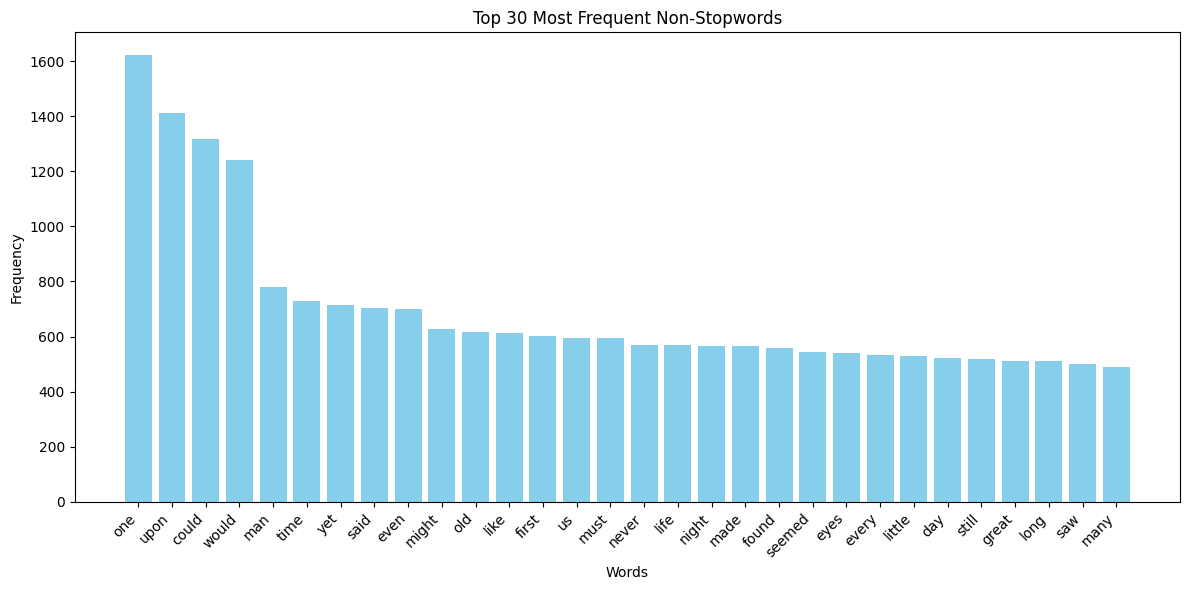

In [28]:
# Stage 1 Analysis (Due Friday 7/18)
# Radhika
df_train.printSchema()
df_train.groupBy('author').count().show()

df_train_pd = df_train.toPandas()

stop_words = set(stopwords.words('english'))
word_counter = Counter() # Initialize Counter

# Iterate over each text entry
for text in df_train_pd['text']:
    words = re.findall(r'\b\w+\b', text.lower())
    filtered_words = [word for word in words if word not in stop_words]  # Exclude stopwords
    word_counter.update(filtered_words) # Lowercase, remove punctuation, and split into words

top_words = word_counter.most_common(30)
print(top_words) #display 30 most frequent non-stop words
words, frequencies = zip(*top_words)  # Unpack into two lists

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 30 Most Frequent Non-Stopwords')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

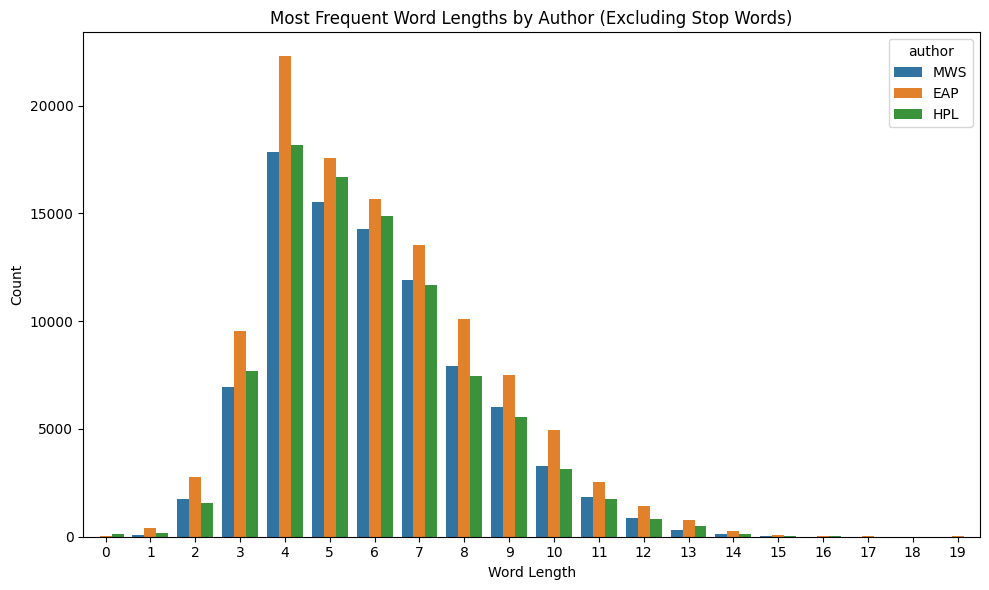

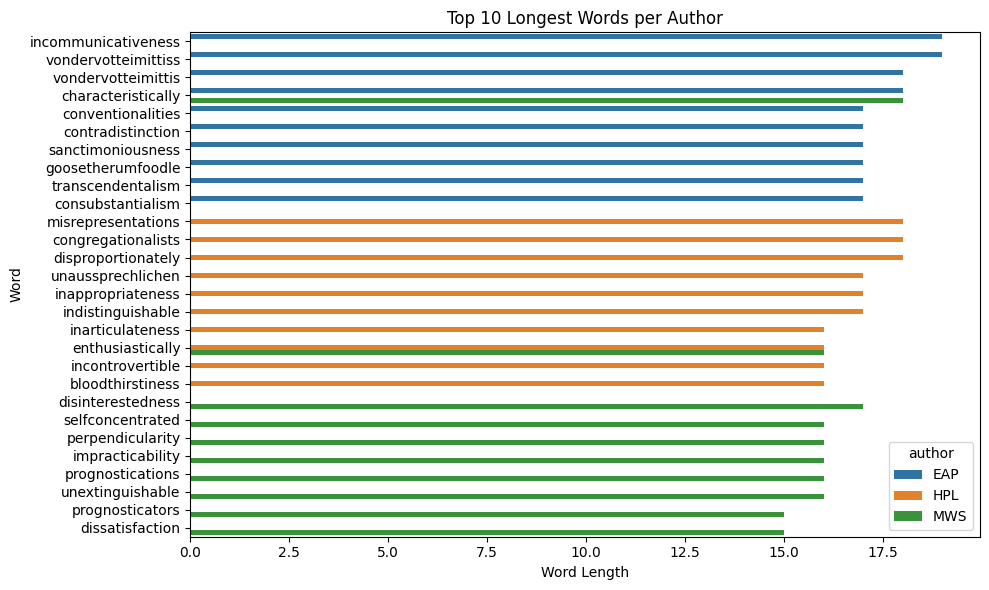

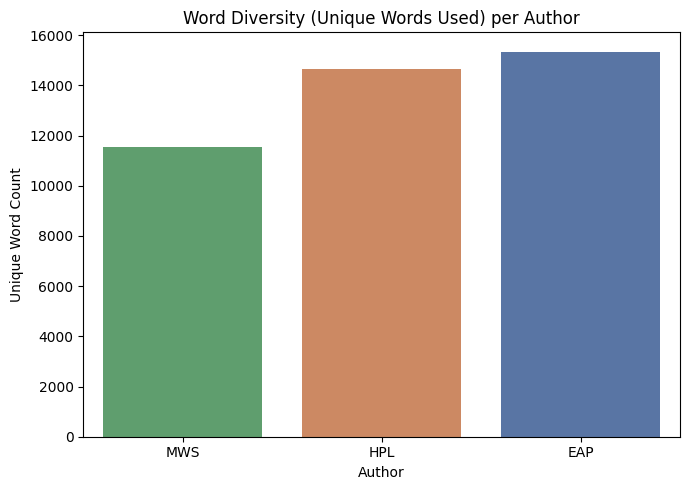

In [29]:
# Stage 1 Visualizations (Due Friday 7/18)
# Claudine

from pyspark.sql.functions import col, split, explode, length, lower, regexp_replace, count, row_number
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

# Clean and lowercase text, remove punctuation
df_train_cleaned = df_train.withColumn("clean_text", lower(regexp_replace(col("text"), r"[^\w\s]", "")))

# Tokenize into words
df_train_words = df_train_cleaned.withColumn("word", explode(split(col("clean_text"), r"\s+")))

# common stop words
stop_words = [
    'the', 'and', 'is', 'in', 'to', 'of', 'a', 'that', 'it', 'on', 'for', 'as', 'with',
    'was', 'at', 'by', 'an', 'be', 'this', 'from', 'or', 'are', 'which', 'but', 'not',
    'have', 'has', 'had', 'they', 'you', 'he', 'she', 'we', 'their', 'its', 'his',
    'her', 'been', 'my', 'i', 'would', 'i', 'you', 'your', 'me', 'myself', 'us', 
    'our', 'ourselves', 'they', 'them', 'their','when', 'where', 'why', 'how', 
    'what', 'who', 'whom', 'which', 'whose', 'there', 'here', 'then', 'now', 'so', 'such'
]

# Remove stop words
df_train_filtered = df_train_words.filter(~col("word").isin(stop_words))

# ---------- CHART 1: Most Frequent Word Lengths ----------
df_word_lengths = df_train_filtered.withColumn("length", length(col("word")))
df_grouped = df_word_lengths.groupBy("author", "length").count()
pdf = df_grouped.toPandas()

# Plot chart 1
plt.figure(figsize=(10, 6))
sns.barplot(data=pdf, x="length", y="count", hue="author")
plt.title("Most Frequent Word Lengths by Author (Excluding Stop Words)")
plt.xlabel("Word Length")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------- CHART 2: Top 10 Longest Words per Author ----------
df_longest = df_word_lengths.groupBy("author", "word") \
    .agg(count("*").alias("count")) \
    .withColumn("length", length(col("word")))

windowSpec = Window.partitionBy("author").orderBy(col("length").desc())
df_top_longest = df_longest.withColumn("rank", row_number().over(windowSpec)).filter(col("rank") <= 10)

pdf_longest = df_top_longest.select("author", "word", "length").toPandas()

# Plot chart 2
plt.figure(figsize=(10, 6))
sns.barplot(data=pdf_longest, x="length", y="word", hue="author")
plt.title("Top 10 Longest Words per Author")
plt.xlabel("Word Length")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# ----- CHART 3: count unique words by author ----------
df_unique_words = df_train_filtered.select("author", "word").distinct()
df_word_diversity = df_unique_words.groupBy("author").count().withColumnRenamed("count", "unique_word_count")

# Convert to pandas
pdf_diversity = df_word_diversity.toPandas()

# Define custom color palette 
palette = {"EAP": "#4C72B0", "HPL": "#DD8452", "MWS": "#55A868"}

# Plot chart3
plt.figure(figsize=(7, 5))
sns.barplot(data=pdf_diversity, x="author", y="unique_word_count", hue="author", palette=palette, legend=False)

plt.title("Word Diversity (Unique Words Used) per Author")
plt.xlabel("Author")
plt.ylabel("Unique Word Count")
plt.tight_layout()
plt.show()

<hr>

### Stage 2 - Feature Extraction
1) Perform TFIDF to quantify word importance <href><https://en.wikipedia.org/wiki/Tf%E2%80%93idf></href>
2) Normalize is scaling or standardizing the numerical features to a standard range or distribution
    - In text mining, normalization vectorizes features with methods like TFIDF, a numerical measurement, to ensure a consistent scale
    - It handles variations in the magnitude of feature values impacting machine-learning algorithm performance. Normalize the features to ensure a similar scale and prevent features with larger values from dominating the analysis or modeling process

In [30]:
# Stage 2 - TFIDF and Normalization (Due Friday 7/18)
# Daniel
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

# Aidan: Added TFIDF for test data
tokenizer = Tokenizer(outputCol='words')
tokenizer.setInputCol('text')
words_data_train = tokenizer.transform(df_train_filtered)

hashingTF = HashingTF(inputCol='words', outputCol='tf')
hashingTF.setNumFeatures(4096) # keep this powers of two: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.HashingTF.html#pyspark.ml.feature.HashingTF
                               # I selected 4096 for no particular reason, this can be tweaked.

tf_data_train = hashingTF.transform(words_data_train)

idf = IDF(minDocFreq=3)
idf.setInputCol('tf')
idf.setOutputCol('tfidf')
idf_model_train = idf.fit(tf_data_train)

tfidf_data_train = idf_model_train.transform(tf_data_train)

In [31]:
tfidf_data_train = tfidf_data_train.drop('tf')

tfidf_data_train.select('tfidf').show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tfidf                                                                                                                                                                          

The data has this structure: `[Vector length], [indicies], [tf-idf values]`

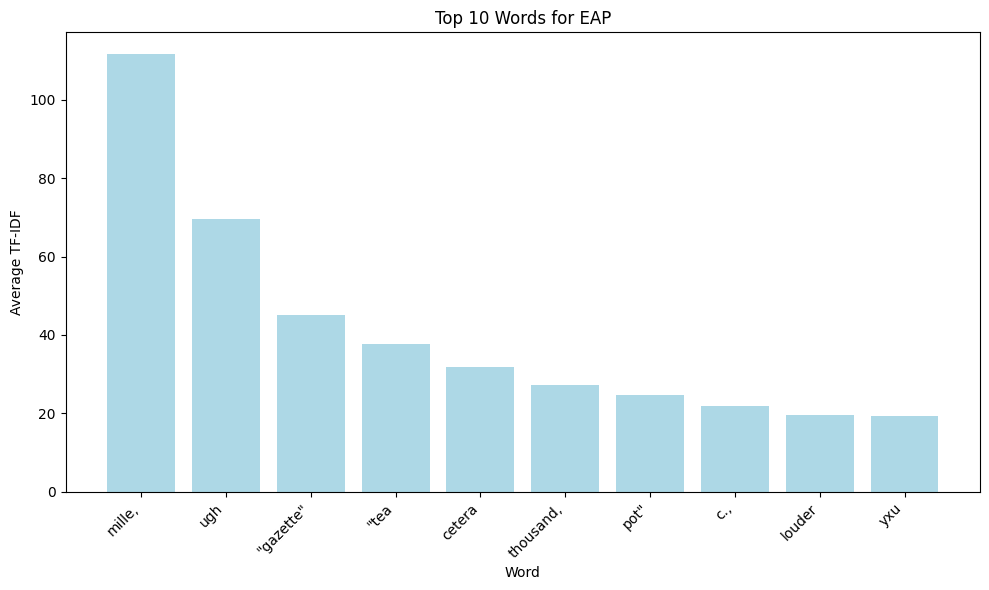

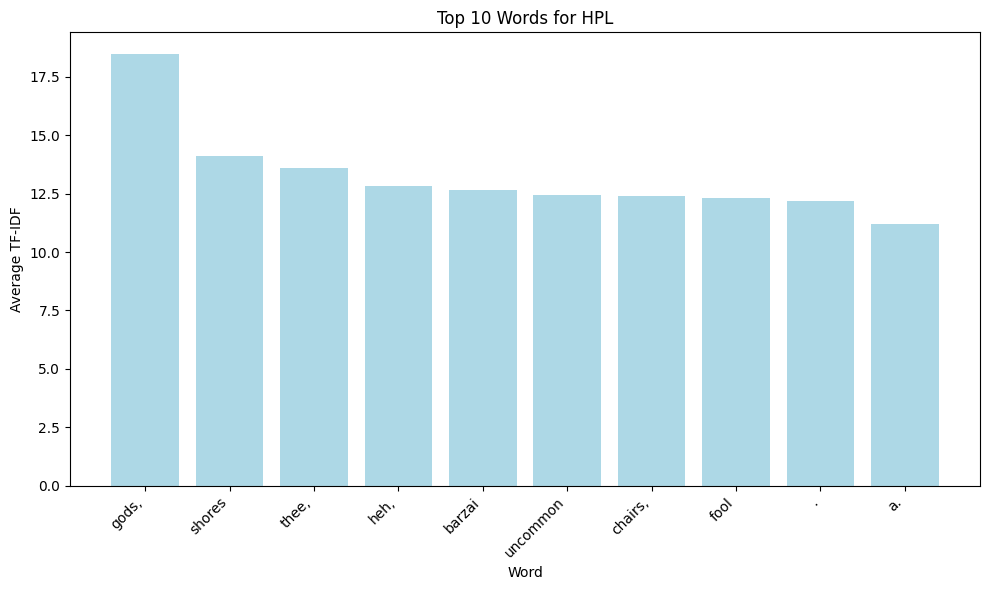

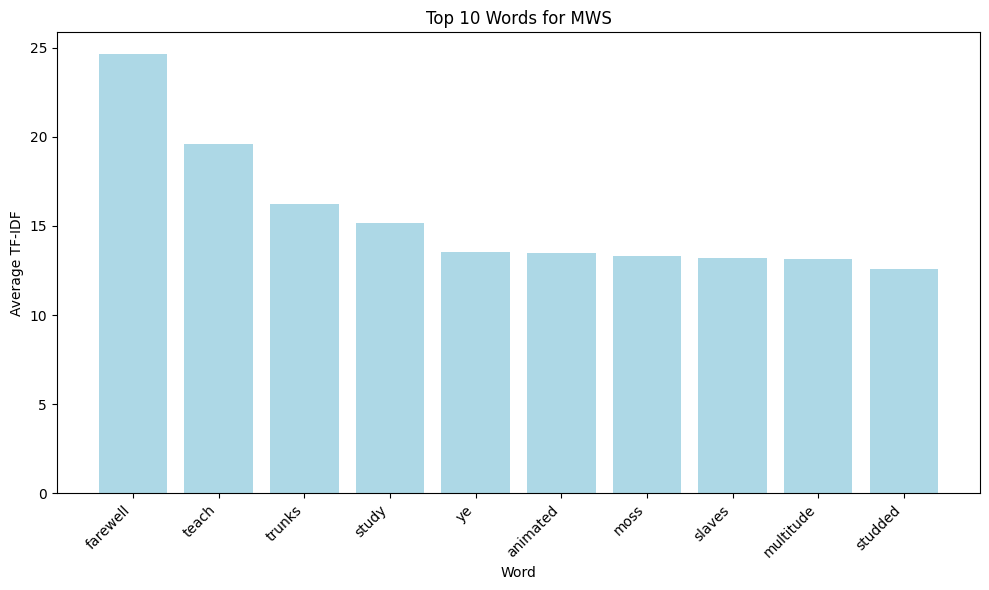

In [32]:
# Stage 2 Visualizations (ex: Most Important Word By Author) (Due Friday 7/18)
# Aidan
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Redo TFIDF: Need to use CountVectorizer here to retain the words for future analysis
cv = CountVectorizer(inputCol='words', outputCol='tf', minDF=3.0, vocabSize=4096)
cv_model = cv.fit(words_data_train)
tf_cv_data = cv_model.transform(words_data_train)
idf_cv = IDF(minDocFreq=3, inputCol='tf', outputCol='tfidf')
idf_cv_model = idf.fit(tf_cv_data)
tfidf_cv_data = idf_cv_model.transform(tf_cv_data).drop('tf')
tfidf_cv_data.cache()

# Here I have to switch to using Pandas, as Spark would have timeout issues when trying to parse the TFIDF dataframe. Since this is just for visualization this should be fine
tfidf_pandas = tfidf_cv_data.select('author', 'tfidf').toPandas()

# Group the tfidf vectors per author
top_words_per_author = defaultdict(list)
for _, row in tfidf_pandas.iterrows():
    author = row['author']
    vector = row['tfidf']
    for index, value in zip(vector.indices, vector.values):
        top_words_per_author[author].append((index, value))

# Now compute the average tfidf value per word per author
avg_tfidf_per_author = {}
vocab = cv_model.vocabulary
for author, terms in top_words_per_author.items():
    # For each term get the sum and counts
    index_sums = defaultdict(lambda: {'sum': 0.0, 'count': 0})
    for index, value in terms:
        index_sums[index]['sum'] += value
        index_sums[index]['count'] += 1
    
    # Now compute the averages
    avg_tfidf = [(vocab[index], data['sum'] / data['count']) for index, data in index_sums.items()]

    # Sort averages by descending average value (element 1 in avg_tfidf above) and get top 10 words
    avg_tfidf = sorted(avg_tfidf, key=lambda x: x[1], reverse=True)[:10]

    # Assign them to the correct author
    avg_tfidf_per_author[author] = pd.DataFrame(avg_tfidf, columns=['word', 'avg(value)'])

# Plot the best words per author
for author, df in avg_tfidf_per_author.items():
    plt.figure(figsize=(10, 6))
    plt.bar(df['word'], df['avg(value)'], color='lightblue')
    plt.xlabel('Word')
    plt.ylabel('Average TF-IDF')
    plt.title(f'Top 10 Words for {author}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

<hr>

### Stage 3 - Machine Learning
1) Perform train/test split
2) Perform algorithmic analysis to assess and predict test labels
    - Use as many algorithms as you need to get a good answer.
    - Supervised: logistic regression, random forest, support vector machines, etc.
    - Unsupervised: K-means, dimensionality reduction, PCA, etc.

In [33]:
# Stage 3 Solution (Due by Monday 7/21)
# Each team member will do 2 algorithms of their choosing

# Train test split for below
train_data, test_data = tfidf_data_train.randomSplit([0.8, 0.2], seed=42)
train_data.cache()
test_data.cache()
print(f"Training set size: {train_data.count()} rows")
print(f"Test set size: {test_data.count()} rows")

Training set size: 230643 rows
Test set size: 57829 rows


In [ ]:
# Aidan: Logistic Regression, Agglomerative Heirarchical Clustering

# ---------- Logistic Regression ----------
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer

# Convert author labels to numeric index
indexer = StringIndexer(inputCol='author', outputCol='label')
indexer_model = indexer.fit(train_data)
indexed_train = indexer_model.transform(train_data)
indexed_test = indexer_model.transform(test_data)

# Train Logisitic Regression Model
lr = LogisticRegression(featuresCol='tfidf', labelCol='label', maxIter=1000, regParam=0.01)
lr_model = lr.fit(indexed_train)

# Predict test data
lr_predictions = lr_model.transform(indexed_test)
print("---------------- Logistic Regression Predictions ----------------")
lr_predictions.select("text", "author", "label", "prediction").show(5, truncate=False)

# ---------- Agglomerative Heirarchical Clustering (Using Bisecting KMeans) ----------


---------------- Logistic Regression Predictions ----------------
+-----------------------------------------------------------------------------------------------+------+-----+----------+
|text                                                                                           |author|label|prediction|
+-----------------------------------------------------------------------------------------------+------+-----+----------+
|Idris was well content with this resolve of mine.                                              |MWS   |2.0  |2.0       |
|I was faint, even fainter than the hateful modernity of that accursed city had made me.        |HPL   |1.0  |1.0       |
|I was faint, even fainter than the hateful modernity of that accursed city had made me.        |HPL   |1.0  |1.0       |
|I was faint, even fainter than the hateful modernity of that accursed city had made me.        |HPL   |1.0  |1.0       |
|Above all, I burn to know the incidents of your own passage through the dark Va

In [35]:
# Daniel: SVC, K-Means


In [36]:
# Claudine: SVM, DBSCAN


In [37]:
# Radhika: Random Forest, PCA

<hr>

### Stage 4 - Evaluation and Visualization
1) Choose a metric strategy to assess algorithmic performance like accuracy, precision, recall, or F1 score
2) Visualize confusion matrix, correlations, and similar
3) Identify important features contributing to classification
4) Write a 2-3 sentence minimum of findings, learnings, and what you would do next

In [38]:
# Stage 4 Solution (Due by Monday 7/21)
# Each team member will evaluate their models

In [39]:
# Aidan

In [40]:
# Daniel

In [41]:
# Claudine

In [42]:
# Radhika